In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 + 2*x + 1

In [3]:
f(2.9)

32.03

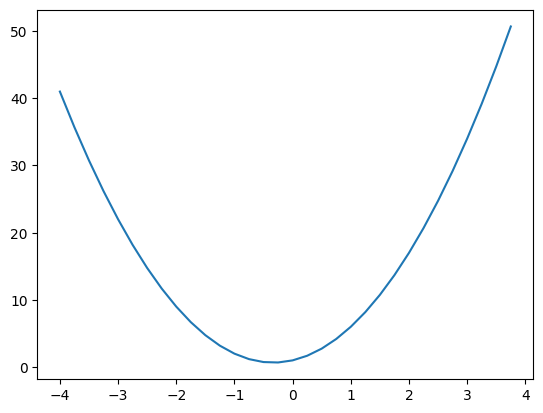

In [4]:
xs = np.arange(-4, 4, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000000001
x = -1/2
(f(h + x) - f (x)) / h 

-1.000000082740371

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

In [7]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c

c += h
d2 = a * b + c

print('d1 = ', d1, 'd2 = ', d2)
print('slope = ', (d2 - d1) / h)


d1 =  4.0 d2 =  4.00001
slope =  0.9999999999621422


In [8]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(uid + n._op, n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


In [11]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88812983123, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

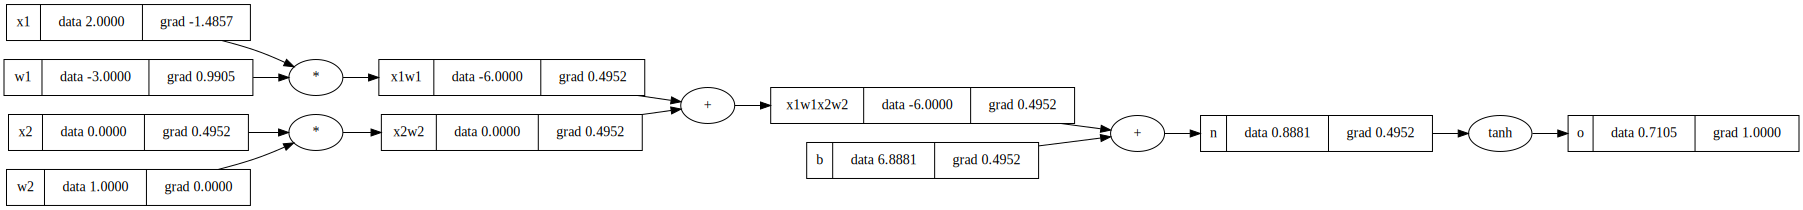

In [12]:
draw_dot(o)

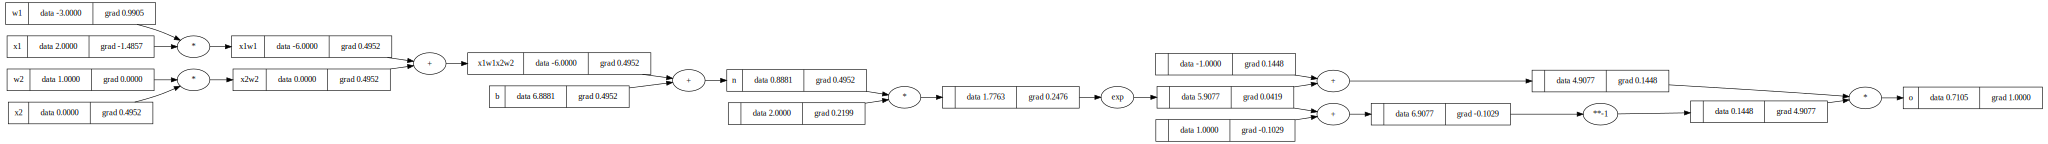

In [13]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88812983123, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [14]:
import torch

In [15]:
x1 = torch.Tensor([2.0]).double()                        ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                        ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                        ; w2.requires_grad = True
b = torch.Tensor([6.881129831237283192839012]).double()               ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print("--------------")
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('b', b.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())



0.7069848374874377
--------------
x2 0.5001724395628613
w1 1.0003448791257226
b 0.5001724395628613
x1 -1.5005173186885838
w2 0.0


In [16]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

        

In [17]:
x = [2.0, 3.0, 1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3814026034357972)

In [18]:
len(n.parameters())

41

In [19]:
xs = [
    [2.0, 3.0, -4.0],
    [1.0, -3.0, -2.0],
    [4.0, -1.0, 1.0],
    [-2.0, 2.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


In [36]:
for k in range(20):

    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0

    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 0.004096504215678004
1 0.004069771872034885
2 0.004043383130488969
3 0.004017331431919252
4 0.0039916103827321355
5 0.00396621374968051
6 0.003941135454876225
7 0.003916369570987158
8 0.0038919103166112825
9 0.003867752051819932
10 0.003843889273863372
11 0.0038203166130315242
12 0.003797028828663553
13 0.0037740208053001593
14 0.003751287548972343
15 0.0037288241836215034
16 0.003706625947645042
17 0.0036846881905626136
18 0.0036630063697981837
19 0.003641576047572996


In [37]:
ypred


[Value(data=0.9596082913957747),
 Value(data=-0.9869929931145996),
 Value(data=-0.960978838693681),
 Value(data=0.9821603625094643)]